## Settings

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import tracemalloc
import random
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score , recall_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Path to the dataset
train_path = './assets/train/'
test_path = './assets/test/'

# Feature extractor (SIFT)
sift = cv2.SIFT_create(contrastThreshold=0.01)

### Create Descriptors

In [5]:
def extract_descriptors_from_image(image_path):
    """
    Extract exactly a specified number of descriptors from an image using SIFT.
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Image not found or invalid: {image_path}")
    
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None or len(descriptors) == 0:
        raise ValueError(f"No descriptors found in image: {image_path}")

    return descriptors

In [6]:
def collect_descriptors_all(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        num_des_class = 0
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    
                    # Append descriptors and corresponding labels
                    all_descriptors += descriptors.tolist()
                    all_labels += [i]*len(descriptors)
                    num_des_class += len(descriptors)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
        num_des_tot += num_des_class
        num_des_class_dist.append(num_des_class)
    print(f'total number of descriptors: {num_des_tot}')
    print(f'number of descriptors per class: {num_des_class_dist}')
    
    # Convert to NumPy arrays
    all_descriptors = np.array(all_descriptors)
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels, num_des_class_dist

In [7]:
def collect_descriptors_with_labels(data_path):
    """
    Collect descriptors and their corresponding labels.
    """
    all_descriptors = []
    all_labels = []
    
    classes = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]

    num_des_tot = 0
    num_des_class_dist = []
    for i, class_name in enumerate(classes):
        class_folder = os.path.join(data_path, class_name)
        # print(f"Processing class: {class_name}")
        
        for image_name in os.listdir(class_folder):
            if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
                image_path = os.path.join(class_folder, image_name)
                try:
                    # Extract descriptors for this image
                    descriptors = extract_descriptors_from_image(image_path)
                    all_descriptors.append(descriptors.tolist())
                    all_labels.append(i)
                except ValueError as e:
                    print(f"Error processing {image_name}: {e}")
    
    # Convert to NumPy arrays
    all_labels = np.array(all_labels)
    
    return all_descriptors, all_labels

In [8]:
# Extract descriptors and labels
descriptors_pool, labels_pool, num_des_class_dist = collect_descriptors_all(train_path)

if len(descriptors_pool) > 100000:
    random_idx = np.random.choice(descriptors_pool.shape[0], 100000, replace=False)
    descriptors_pool = descriptors_pool[random_idx]
    labels_pool = labels_pool[random_idx]
print(f'number of remained descriptors: {len(descriptors_pool)}')
print("Descriptor extraction completed.")

total number of descriptors: 107604
number of descriptors per class: [16979, 12121, 6756, 9669, 12299, 15063, 16334, 6954, 3223, 8206]
number of remained descriptors: 100000
Descriptor extraction completed.


# Q3. RF codebook

## Construct RF codebook

In [9]:
def create_leaf_indices(rf_code):
    leaf_indices = []
    for tree in rf_code.estimators_:
        # Mask for leaf nodes
        is_leaf = tree.tree_.children_left == -1
        # Collect only leaf node indices
        leaf_indices.append(np.where(is_leaf)[0])
    leaf_indices = np.array(leaf_indices)
    return leaf_indices

In [10]:
def get_max_depth(rf_code):
    tree_depths = [estimator.tree_.max_depth for estimator in rf_code.estimators_]
    max_depth = max(tree_depths)
    return max_depth

In [11]:
# default_settings / codebook construction
code_n_estimators = 4
code_max_depth = 4
code_randomness = 0.7


rf_code = RandomForestClassifier(n_estimators=code_n_estimators, max_depth=code_max_depth, bootstrap=True, random_state=None, max_samples=code_randomness, max_features=code_randomness, criterion='entropy')
rf_code.fit(descriptors_pool, labels_pool.ravel())

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=0.7,
                       max_samples=0.7, n_estimators=4)

In [12]:
# 하나의 이미지에 대한 bag of words를 구하는 거!
def create_rf_histogram(descriptors, rf_code, leaf_indices, max_leaf_nodes):
    # Step 1: Apply descriptors to the forest to get leaf indices
    # des_indices는 tree의 전체 node에 대한 index
    
    des_indices = rf_code.apply(descriptors)  # Shape: (n_descriptors, n_trees)

    # Step 2: Convert node index to leaf index
    converted_indices = np.zeros_like(des_indices)
    for tree_idx in range(des_indices.shape[1]):  # Loop over each tree
        leaf_map = {leaf: idx for idx, leaf in enumerate(leaf_indices[tree_idx])}
        converted_indices[:, tree_idx] = [leaf_map[val] for val in des_indices[:, tree_idx]]

    # Step 3: one-hot encoding and concatenate
    one_hot_encoded = []
    for row in converted_indices:
        row_one_hot = []
        # tree 마다 one-hot encoding을 하나씩 만들어서 concatenate
        for leaf_idx in row:
            # Generate a one-hot vector of size max_leaf_nodes
            one_hot_vector = np.zeros(max_leaf_nodes)
            one_hot_vector[leaf_idx] = 1
            row_one_hot.append(one_hot_vector)
        # Concatenate the one-hot vectors for each tree
        one_hot_encoded.append(np.concatenate(row_one_hot))
    
    # Step 4: Normalized histogram -> image 마다 descriptors 개수가 달라서 normalize 해야 함
    one_hot_encoded = np.array(one_hot_encoded)
    histogram = one_hot_encoded.sum(axis=0) / one_hot_encoded.sum()

    return histogram

In [13]:
def create_rf_histogram_time(descriptors, rf_code, leaf_indices, max_leaf_nodes):
    start_time = time.perf_counter()    
    des_indices = rf_code.apply(descriptors)  # Shape: (n_descriptors, n_trees)
    vq_time = time.perf_counter() - start_time

    converted_indices = np.zeros_like(des_indices)
    for tree_idx in range(des_indices.shape[1]):  # Loop over each tree
        leaf_map = {leaf: idx for idx, leaf in enumerate(leaf_indices[tree_idx])}
        converted_indices[:, tree_idx] = [leaf_map[val] for val in des_indices[:, tree_idx]]

    one_hot_encoded = []
    for row in converted_indices:
        row_one_hot = []
        for leaf_idx in row:
            one_hot_vector = np.zeros(max_leaf_nodes)
            one_hot_vector[leaf_idx] = 1
            row_one_hot.append(one_hot_vector)
        one_hot_encoded.append(np.concatenate(row_one_hot))
        
    one_hot_encoded = np.array(one_hot_encoded)
    histogram = one_hot_encoded.sum(axis=0) / one_hot_encoded.sum()

    return histogram, vq_time

In [14]:
def vq_process_time(data_descriptors, rf_code):
    vq_time_tot = 0

    leaf_indices = create_leaf_indices(rf_code)
    max_leaf_nodes = np.pow(2, get_max_depth(rf_code))

    data_bow = []
    for descriptors in data_descriptors:
        image_bow, vq_time = create_rf_histogram_time(descriptors, rf_code, leaf_indices, max_leaf_nodes)
        data_bow.append(image_bow)
        vq_time_tot += vq_time
    data_bow = np.array(data_bow)

    return data_bow, vq_time_tot

### Prepare dataset

In [15]:
def vq_process(data_descriptors, rf_code):
    leaf_indices = create_leaf_indices(rf_code)
    max_leaf_nodes = np.pow(2, get_max_depth(rf_code))

    data_bow = []
    for descriptors in data_descriptors:
        image_bow = create_rf_histogram(descriptors, rf_code, leaf_indices, max_leaf_nodes)
        data_bow.append(image_bow)
    data_bow = np.array(data_bow)

    return data_bow

In [16]:
# Create Train data
train_descriptors, train_labels = collect_descriptors_with_labels(train_path)
print("Train descriptor extraction completed.")

start_time = time.perf_counter()
train_bow = vq_process(train_descriptors, rf_code)
vq_time = time.perf_counter() - start_time

print(f'vector quantization time for train data: {vq_time}')

x_train = train_bow
y_train = train_labels

Train descriptor extraction completed.
vector quantization time for train data: 0.6213704000692815


In [17]:
# Extract test descriptors and labels
test_descriptors, test_labels = collect_descriptors_with_labels(test_path)
print("Descriptor extraction completed.")

start_time = time.perf_counter()
test_bow = vq_process(test_descriptors, rf_code)
vq_time = time.perf_counter() - start_time

print(f'vector quantization test for train data: {vq_time}')

x_test = test_bow
y_test = test_labels

Descriptor extraction completed.
vector quantization test for train data: 0.6811436000280082


## Find best codebook

### RF Classifier with default settings

In [18]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

In [19]:
# Default Settings
code_n_estimators = 4
code_max_depth = 4
code_randomness = 0.7

In [20]:
# Parameter list
code_n_estimators_list = [i for i in range(1,7)]
code_max_depth_list = [i for i in range(1,7)]
code_randomness_list = [i*0.1 for i in range(5,11)]

In [18]:
accuracy_list = []
n_iter = 10

for n_estimators in code_n_estimators_list:
    rf_code = RandomForestClassifier(n_estimators=n_estimators, max_depth=4, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
    rf_code.fit(descriptors_pool, labels_pool.ravel())

    x_train = vq_process(train_descriptors, rf_code)
    y_train = train_labels
    
    x_test = vq_process(test_descriptors, rf_code)
    y_test = test_labels

    avg_accuracy = 0
    for i in range(n_iter):
        y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test)
        avg_accuracy +=accuracy_score(y_test.T, y_test_pred)
    
    accuracy_list.append(avg_accuracy/n_iter)

max_index = accuracy_list.index(max(accuracy_list))
print(f'best number of estimators: {code_n_estimators_list[max_index]}')

print(accuracy_list)

best number of estimators: 6
[0.41600000000000004, 0.42666666666666664, 0.46799999999999997, 0.476, 0.4666666666666667, 0.4779999999999999]


In [19]:
accuracy_list = []
n_iter = 10

for max_depth in code_max_depth_list:
    rf_code = RandomForestClassifier(n_estimators=4, max_depth=max_depth, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
    rf_code.fit(descriptors_pool, labels_pool.ravel())

    x_train = vq_process(train_descriptors, rf_code)
    y_train = train_labels
    
    x_test = vq_process(test_descriptors, rf_code)
    y_test = test_labels

    avg_accuracy = 0
    for i in range(n_iter):
        y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test)
        avg_accuracy +=accuracy_score(y_test.T, y_test_pred)
    
    accuracy_list.append(avg_accuracy/n_iter)

max_index = accuracy_list.index(max(accuracy_list))
print(f'best maximum depth: {code_max_depth_list[max_index]}')

print(accuracy_list)

best maximum depth: 5
[0.2673333333333333, 0.354, 0.38466666666666666, 0.46266666666666667, 0.4966666666666667, 0.4966666666666667]


In [20]:
accuracy_list = []
n_iter = 10

for randomness in code_randomness_list:
    rf_code = RandomForestClassifier(n_estimators=4, max_depth=5, bootstrap=True, random_state=None, max_samples=randomness, max_features=randomness, criterion='entropy')
    rf_code.fit(descriptors_pool, labels_pool.ravel())

    x_train = vq_process(train_descriptors, rf_code)
    y_train = train_labels
    
    x_test = vq_process(test_descriptors, rf_code)
    y_test = test_labels

    avg_accuracy = 0
    for i in range(n_iter):
        y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test)
        avg_accuracy +=accuracy_score(y_test.T, y_test_pred)
    
    accuracy_list.append(avg_accuracy/n_iter)


max_index = accuracy_list.index(max(accuracy_list))
print(f'best randomness: {code_randomness_list[max_index]}')

print(accuracy_list)

best randomness: 0.6000000000000001
[0.48933333333333334, 0.5026666666666666, 0.4726666666666667, 0.4866666666666667, 0.4873333333333334, 0.46733333333333327]


### VQ Time

In [ ]:
#  Best Settings
code_best_estimators = 4
code_best_depth = 5
code_best_randomness = 0.6

accuracy_list = []
n_iter = 1

avg_codebook_time = 0
avg_vq_time = 0
avg_accuracy = 0

for i in range(n_iter):
    start_time = time.perf_counter()
    rf_code = RandomForestClassifier(n_estimators=code_best_estimators, max_depth=code_best_depth, bootstrap=True, random_state=None, max_samples=code_best_randomness, max_features=code_best_randomness, criterion='entropy')
    rf_code.fit(descriptors_pool, labels_pool.ravel())
    avg_codebook_time += time.perf_counter() - start_time

    start_time = time.perf_counter()
    rf_code.apply(train_descriptors)
    vq_time = time.perf_counter() - start_time
    
    x_train, vq_time = vq_process_time(train_descriptors, rf_code)
    avg_vq_time += vq_time
    y_train = train_labels
    
    x_test = vq_process(test_descriptors, rf_code)
    y_test = test_labels

    y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test)
    avg_accuracy +=accuracy_score(y_test.T, y_test_pred)
    
print(f'avg accuracy: {avg_accuracy/n_iter}')
print(f'avg codebook time: {avg_codebook_time/n_iter}')
print(f'avg vq time: {avg_vq_time/n_iter}')

avg accuracy: 0.4706666666666667
avg codebook time: 2.1727469200151974
avg vq time: 0.35379552028607575


In [ ]:
# Compare with two-pixel test
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

n_pairs = x_train.shape[1]

start_time = time.perf_counter()
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
tp_const_time = time.perf_counter() - start_time

y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train_2pix, y_train, x_test_2pix)
accuracy = accuracy_score(y_test.T, y_test_pred)
print(accuracy)

### Codebook Time complexity comparison

In [21]:
train_descriptors_list = []
for i in range(len(train_descriptors)):
    for j in range(len(train_descriptors[i])):
        train_descriptors_list.append(train_descriptors[i][j])

train_descriptors_list = np.array(train_descriptors_list)

In [ ]:
# Time for codebook construction time
code_best_depth = 5
code_best_randomness = 0.6

n_estimators_list = [i for i in range(1,10)]
n_iter = 10

avg_time_list = []
codebook_size = [estimators*np.pow(2,code_best_depth) for estimators in n_estimators_list]

rf_code_list = []

for estimators in n_estimators_list:
    avg_time = 0
    for i in range(n_iter):
        start_time = time.perf_counter()
        
        rf_code = RandomForestClassifier(n_estimators=estimators, max_depth=code_best_depth, bootstrap=True, random_state=None, max_samples=code_best_randomness, max_features=code_best_randomness, criterion='entropy')
        rf_code.fit(descriptors_pool, labels_pool.ravel())
        
        avg_time += time.perf_counter() - start_time
    rf_code_list.append(rf_code)

    avg_time_list.append(avg_time/n_iter)

In [ ]:
# Time for vector quantization time
avg_vq_time_list = []
# n_iter = len(train_descriptors)
# for rf_code in rf_code_list:
#     avg_vq_time = 0
#     for i in range(n_iter):
#         start_time = time.perf_counter()
#         rf_code.apply(train_descriptors[i])
#         avg_vq_time += time.perf_counter() - start_time
#     # avg_vq_time_list.append(avg_vq_time/n_iter)

n_iter = len(train_descriptors)
for rf_code in rf_code_list:
    avg_vq_time = 0
    for i in range(n_iter):
        start_time = time.perf_counter()
        rf_code.apply(train_descriptors[i])
        avg_vq_time += time.perf_counter() - start_time
    avg_vq_time_list.append(avg_vq_time/n_iter)

In [ ]:
# results from Q1.ipynb and Q2.ipynb
q2_avg_time = [2.548782,
    8.89768476, 
    17.3841378 ,
    28.0607884,
    40.59742532,
    55.4671402 ,
    73.12054278,
    92.73077332,
    110.66663548]

q2_avg_vq_time = [0.00397523733942459,
 0.004002210004255175,
 0.004020090005360544,
 0.0040823926667993265,
 0.004069500669526557,
 0.004059693327484032,
 0.004069020003080368,
 0.00406204867331932,
 0.004096894660033285]

In [2]:
# Plot accuracy on the first subplot
plt.plot(codebook_size, q2_avg_time, label='K-means codebook', marker='s', linestyle='-', color='r')
plt.plot(codebook_size, avg_time_list, label='RF codebook', marker='s', linestyle='-', color='b')
plt.xlabel('Codebook Size', fontsize=20)
plt.ylabel('Runtime (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Codebook construction time')
plt.legend(fontsize=15)
plt.grid(True)

NameError: name 'plt' is not defined

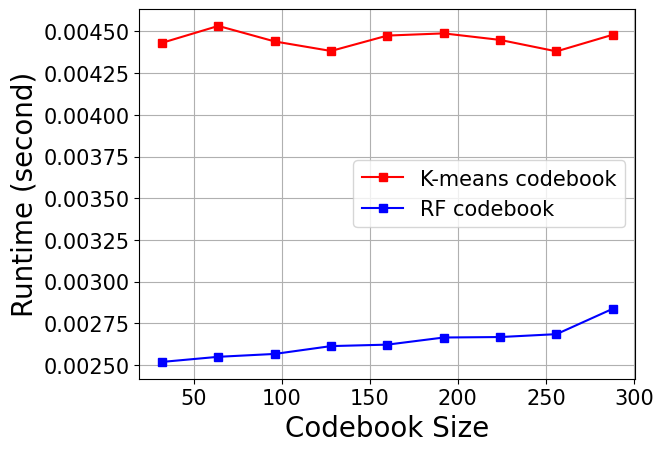

In [33]:
# Plot accuracy on the first subplot
plt.plot(codebook_size, q2_avg_vq_time, label='K-means codebook', marker='s', linestyle='-', color='r')
plt.plot(codebook_size, avg_vq_time_list, label='RF codebook', marker='s', linestyle='-', color='b')
plt.xlabel('Codebook Size', fontsize=20)
plt.ylabel('Runtime (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Vector quantization time')
plt.legend(fontsize=15)
plt.grid(True)

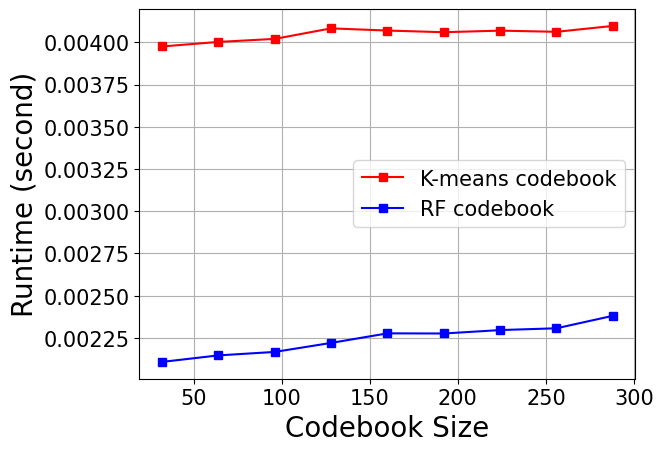

In [47]:
# Plot accuracy on the first subplot
plt.plot(codebook_size, q2_avg_vq_time, label='K-means codebook', marker='s', linestyle='-', color='r')
plt.plot(codebook_size, avg_vq_time_list, label='RF codebook', marker='s', linestyle='-', color='b')
plt.xlabel('Codebook Size', fontsize=20)
plt.ylabel('Runtime (second)', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
# plt.title('Vector quantization time')
plt.legend(fontsize=15)
plt.grid(True)

In [44]:
avg_vq_time_list

[0.31980669000186024,
 0.32296973021002484,
 0.3301874198834412,
 0.33263694021152335,
 0.33597822006558997,
 0.344751489860937,
 0.34605844017351045,
 0.35405974022578446,
 0.3580951402895153]

## RF Classifier

In [33]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

### Change one parameter per experiment

In [26]:
def q2_measurements(parameter_list, change_type, n_iter):
    train_accuracy_list = []
    test_accuracy_list = []

    train_time_list = []
    test_time_list = []

    for parameter in parameter_list:
        avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0, 0, 0, 0

        for i in range(n_iter):
            if change_type == 'estimator':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=parameter, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
            elif change_type == 'depth':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=parameter, bootstrap=True, random_state=None, max_samples=0.7, max_features=0.7, criterion='entropy')
            elif change_type == 'randomness':
                y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=parameter, max_features=parameter, criterion='entropy')
            avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
            avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
            avg_train_time += train_time
            avg_test_time += test_time
        
        train_accuracy_list.append(avg_train_accuracy/n_iter)
        test_accuracy_list.append(avg_test_accuracy/n_iter)
        train_time_list.append(avg_train_time/n_iter)
        test_time_list.append(avg_test_time/n_iter)
    
    return train_accuracy_list, test_accuracy_list, train_time_list, test_time_list        


In [27]:
def draw_accuracy_graph(parameter_list, change_type, train_accuracy_list, test_accuracy_list):
    plt.plot(parameter_list, train_accuracy_list, label='Train Accuracy', marker='s', linestyle='-', color='r')
    plt.plot(parameter_list, test_accuracy_list, label='Test Accuracy', marker='s', linestyle='-', color='b')
    plt.xticks(parameter_list)
    if change_type == 'estimator':
        plt.xlabel('Number of estimators', fontsize=20)
    elif change_type == 'depth':
        plt.xlabel('Maximum depth', fontsize=20)
    elif change_type == 'randomness':
        plt.xlabel('Randomness (ratio)', fontsize=20)
    plt.ylabel('Accuracy', fontsize=20)
    # plt.title('Accuracy over number of estimators')
    plt.legend(fontsize=15)
    plt.grid(True)

In [28]:
def draw_time_graph(parameter_list, change_type, train_time_list, test_time_list):
    plt.plot(parameter_list, train_time_list, label='Train Time', marker='s', linestyle='-', color='r')
    plt.plot(parameter_list, test_time_list, label='Test Time', marker='s', linestyle='-', color='b')
    plt.xticks(parameter_list)
    if change_type == 'estimator':
        plt.xlabel('Number of estimators', fontsize=20)
    elif change_type == 'depth':
        plt.xlabel('Maximum depth', fontsize=20)
    elif change_type == 'randomness':
        plt.xlabel('Randomness (ratio)', fontsize=20)
    plt.ylabel('Run time (second)', fontsize=20)
    
    plt.legend(fontsize=15)
    plt.grid(True)

In [29]:
n_estimators_list = [i*30 for i in range(1,11)]
max_depth_list = [i for i in range(1, 16)]
randomness_parameter = [0.1 * i for i in range(1,11)]

In [78]:
# change number of estimators
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(n_estimators_list, 'estimator', 10)

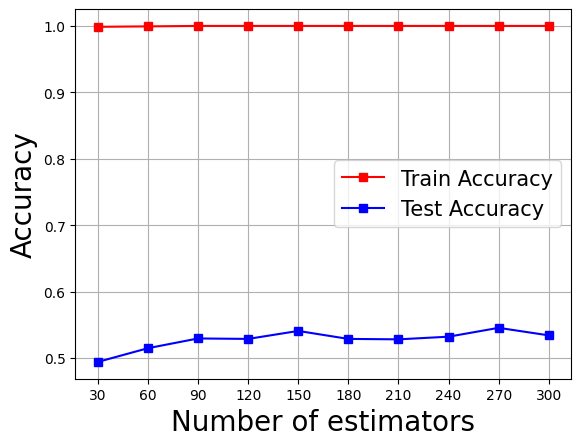

In [79]:
draw_accuracy_graph(n_estimators_list, 'estimator', train_accuracy_list, test_accuracy_list)

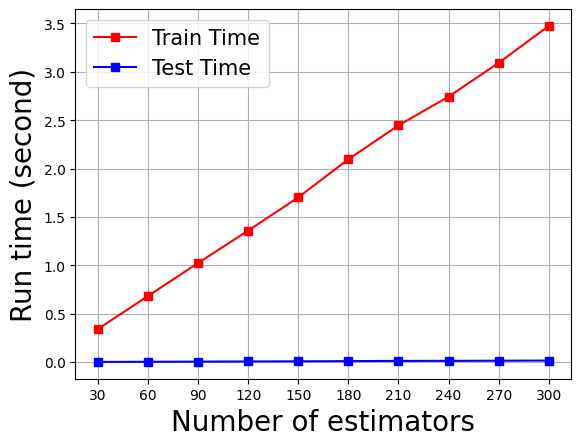

In [80]:
draw_time_graph(n_estimators_list, 'estimator', train_time_list, test_time_list)

In [81]:
# change maximum depth
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(max_depth_list, 'depth', 10)

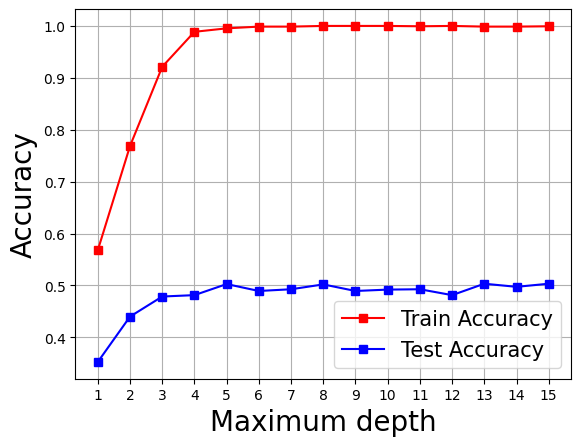

In [82]:
draw_accuracy_graph(max_depth_list, 'depth', train_accuracy_list, test_accuracy_list)

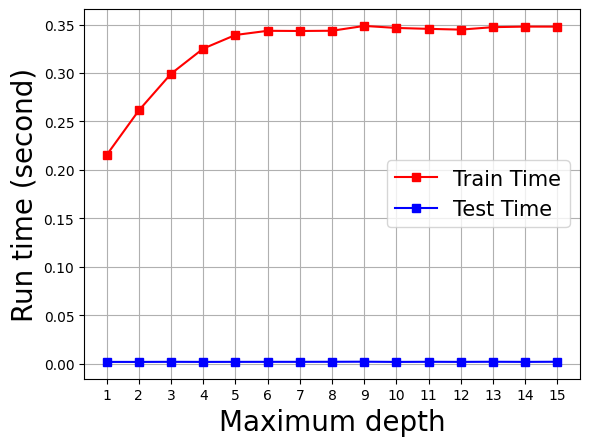

In [83]:
draw_time_graph(max_depth_list, 'depth', train_time_list, test_time_list)

In [84]:
# change randomness
train_accuracy_list, test_accuracy_list, train_time_list, test_time_list = q2_measurements(randomness_parameter, 'randomness', 10)

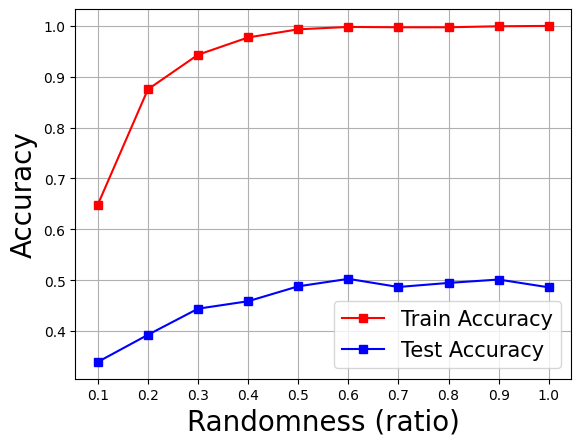

In [85]:
draw_accuracy_graph(randomness_parameter, 'randomness', train_accuracy_list, test_accuracy_list)

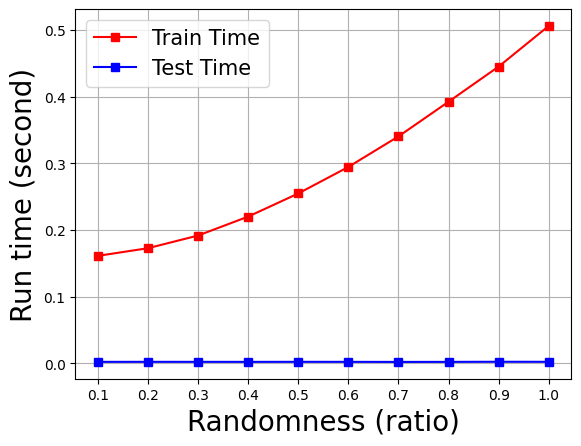

In [86]:
draw_time_graph(randomness_parameter, 'randomness', train_time_list, test_time_list)

In [36]:
# Best settings
best_estimators = 150
best_depth = 8
best_randomness = 0.6

In [37]:
# Best average accuracy
n_iter = 10
avg_accuracy = 0

for i in range(n_iter):
    y_train_pred, y_test_pred, train_time, test_time, _, _, _ = RF_classification(x_train, y_train, x_test, n_estimators=best_estimators, max_depth=best_depth, max_samples=best_randomness, max_features=best_randomness)
    avg_accuracy += accuracy_score(y_test.T, y_test_pred)

avg_accuracy /= n_iter

print(avg_accuracy)

0.532


### Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test.T, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_percentage, annot=True, fmt='.2f', cmap='Blues', cbar=False)
    # plt.title("Confusion Matrix")
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)
    plt.tight_layout()
    plt.show()

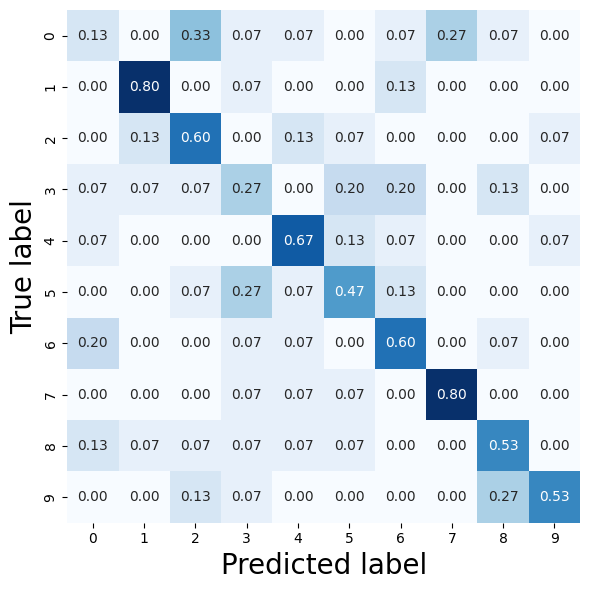

In [ ]:
plot_confusion_matrix(y_test, y_test_pred)

### Axis aligned test

In [ ]:
n_iter = 10
avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0,0,0,0

for i in range(10):
    y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=best_estimators, max_depth=best_depth, bootstrap=True, random_state=None, max_samples=best_randomness, max_features=best_randomness, criterion='entropy')
    avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
    avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
    avg_train_time += train_time
    avg_test_time += test_time

print(f'average train time: {avg_train_time/n_iter}')
print(f'avegrage train accuracy: {avg_train_accuracy/n_iter}')
print('\n')

print(f'average test time: {avg_test_time/n_iter}')
print(f'average test_accuracy: {avg_test_accuracy/n_iter}')
print('\n')

In [ ]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

In [ ]:
n_pairs = x_train.shape[1]

start_time = time.perf_counter()
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
tp_const_time = time.perf_counter() - start_time

n_iter = 10
avg_train_accuracy, avg_test_accuracy, avg_train_time, avg_test_time = 0,0,0,0

for i in range(n_iter):
    y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, n_estimators=best_estimators, max_depth=best_depth, bootstrap=True, random_state=None, max_samples=best_randomness, max_features=best_randomness, criterion='entropy')
    avg_train_accuracy += accuracy_score(y_train.T, y_train_pred)
    avg_test_accuracy += accuracy_score(y_test.T, y_test_pred)
    avg_train_time += train_time
    avg_test_time += test_time

print(f'average train time: {tp_const_time + avg_train_time/n_iter}')
print(f'avegrage train accuracy: {avg_train_accuracy/n_iter}')
print('\n')

print(f'average test time: {tp_const_time + avg_test_time/n_iter}')
print(f'average test_accuracy: {avg_test_accuracy/n_iter}')
print('\n')

## Previous

### Axis-aligned test

In [11]:
def RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy'):
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, bootstrap=bootstrap, random_state=random_state, max_samples=max_samples, max_features=max_features, criterion=criterion)
    # Train ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()
    
    rf_clf.fit(x_train, y_train.ravel())
    
    train_time = time.perf_counter() - start_time
    current, train_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    y_train_pred = rf_clf.predict(x_train)

    # Test ----------------------------------------------------------
    tracemalloc.start() 
    start_time = time.perf_counter()

    y_test_pred = rf_clf.predict(x_test)

    test_time = time.perf_counter()- start_time
    current, test_peak_memory = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # Retrieve the maximum depth of each tree in the forest
    tree_depths = [estimator.tree_.max_depth for estimator in rf_clf.estimators_]
    max_tree_depth = max(tree_depths)

    return y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth

In [12]:
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train, y_train, x_test, n_estimators=30, max_depth=5, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.17165810003643855
train accuracy: 0.9866666666666667


test time: 0.0018428000039421022
test_accuracy: 0.42


test_precision: 0.45734997369032904
test_recall: 0.42000000000000004


max tree depth: 5


### Two-pixel test

In [13]:
def create_two_pixel_features(x_train, x_test, n_pairs=None, random_seed=None):
    x_combined = np.concatenate([x_train, x_test], axis=1)

    n_features, n_samples = x_combined.shape

    # Set random seed if provided
    if random_seed is not None:
        random.seed(random_seed)

    # Generate all unique pairs of features where i != j
    feature_pairs = [(i, j) for i in range(n_features) for j in range(i + 1, n_features)]

    # If n_pairs is specified, randomly select a subset of feature pairs
    if n_pairs is not None and n_pairs < len(feature_pairs):
        feature_pairs = random.sample(feature_pairs, n_pairs)
    
    # Initialize a new features matrix for pairwise differences
    new_features = np.zeros((len(feature_pairs), n_samples))

    # Fill in the new features with pairwise differences
    for idx, (i, j) in enumerate(feature_pairs):
        new_features[idx, :] = x_combined[i, :] - x_combined[j, :]

    x_train_2pix = new_features[:, :x_train.shape[1]]
    x_test_2pix = new_features[:, x_train.shape[1]:]

    return x_train_2pix.T, x_test_2pix.T

In [14]:
n_pairs = x_train.shape[1]
# n_pairs = 100
x_train_2pix, x_test_2pix = create_two_pixel_features(x_train.T, x_test.T, n_pairs=n_pairs, random_seed=0)
y_train_pred, y_test_pred, train_time, test_time, train_peak_memory, test_peak_memory, max_tree_depth = RF_classification(x_train_2pix, y_train, x_test_2pix, n_estimators=30, max_depth=10, bootstrap=True, random_state=None, max_samples=0.7, max_features="sqrt", criterion='entropy')

train_accuracy = accuracy_score(y_train.T, y_train_pred)
test_accuracy = accuracy_score(y_test.T, y_test_pred)
test_precision = precision_score(y_test.T, y_test_pred, average= "macro", zero_division=0)
test_recall = recall_score(y_test.T, y_test_pred, average= "macro", zero_division=0)

print(f'train time: {train_time}')
print(f'train accuracy: {train_accuracy}')
print('\n')

print(f'test time: {test_time}')
print(f'test_accuracy: {test_accuracy}')
print('\n')

print(f'test_precision: {test_precision}')
print(f'test_recall: {test_recall}')
print('\n')

print(f'max tree depth: {max_tree_depth}')

train time: 0.1733814000035636
train accuracy: 0.9933333333333333


test time: 0.0018493999959900975
test_accuracy: 0.3333333333333333


test_precision: 0.38338143549814035
test_recall: 0.33333333333333337


max tree depth: 10
